# Prediction of Adverse Drug Reaction (ADR) Outcome using FDA Adverse Event Reporting System Data (FAERS)

This just a demonstration of feasibility of the outcome prediction using the public dataset available [here](https://open.fda.gov/downloads/). This datset contains quarterly reports of drug adverse events from 2004 to 2019. Here I consider Q4 of 2018 which is only about 1.6% of the data. 

## Read Data



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
warnings.filterwarnings('ignore')
import sys
print(sys.version)

3.7.5 (default, Nov  1 2019, 21:02:10) 
[Clang 9.0.0 (clang-900.0.39.2)]


In [2]:
#reac = pd.read_csv('reac2018q4.csv',index_col=[0,1])
#ther = pd.read_csv('ther2018q4.csv',index_col=[0,1])
#rpsr = pd.read_csv('rpsr2018q4.csv',index_col=[0,1])
demo = pd.read_csv('demo2018q4.csv',index_col=[0,1])
drug = pd.read_csv('drug2018q4.csv',index_col=[0,1])
indi = pd.read_csv('indi2018q4.csv',index_col=[0,1])
outc = pd.read_csv('outc2018q4.csv',index_col=[0,1])

For now we just look are demographics, drug, indications and outcome. Each patient might have multiple adverse events reported, therefore we consider both primary patient id and case id for indexing.

In [369]:
dat1 = pd.merge(outc,drug,on=['primaryid','caseid'],how='left')
dat2 = pd.merge(dat1,demo,on=['primaryid','caseid'],how='left')
dat = pd.merge(dat2,indi,on=['primaryid','caseid'],how='left')

## Preprocess

Preprocess the data to make outcomes readable and unify the units for age and weight.

In [370]:
d = dict(DE='Death',LT='Life-Threatening', HO='Hospitalization', DS='Disability', CA='Congenital Anomaly', RI='Required Intervention', OT='Other Serious')
dat['outc_cod'].replace(to_replace=d, inplace=True)

dat['age_year']= float('nan')
dat['age_year'] = np.where(dat['age_cod']=='DY', dat['age'] / 365 , dat['age_year'])
dat['age_year'] = np.where(dat['age_cod']=='MON', dat['age'] / 12 , dat['age_year'])
dat['age_year'] = np.where(dat['age_cod']=='DEC', dat['age'] * 10 , dat['age_year'])
dat['age_year'] = np.where(dat['age_cod']=='WK', dat['age'] / 52 , dat['age_year'])
dat['age_year'] = np.where(dat['age_cod']=='HR', dat['age'] / (24*365) , dat['age_year'])
dat['age_year'] = np.where(dat['age_cod']=='YR', dat['age']  , dat['age_year'])

#Convert all weights to KG
dat['wt_kg'] = float('nan')
dat['wt_kg'] = np.where(dat['wt_cod']=='LBS',dat['wt']/453.592,dat['wt_kg'])
dat['wt_kg'] = np.where(dat['wt_cod']=='KG',dat['wt'],dat['wt_kg'])



## Explore

Now let's visualize some variables for different outcomes to visually check if there are some differences. 

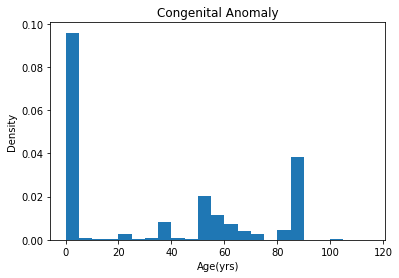

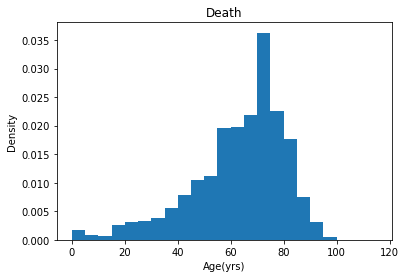

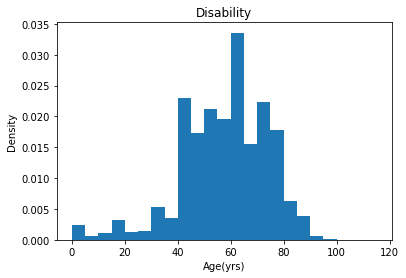

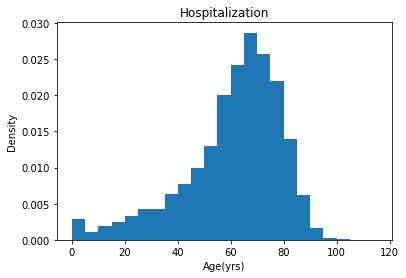

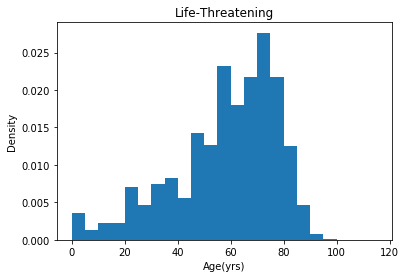

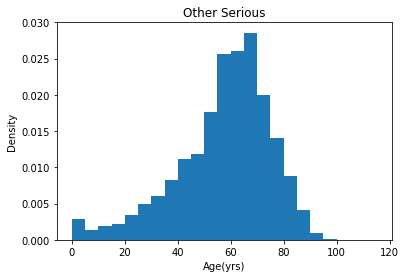

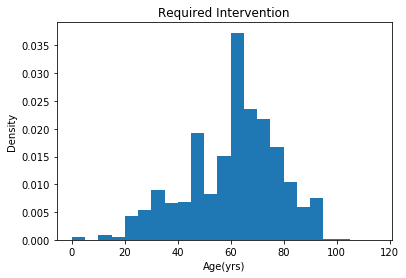

In [371]:
grouped = dat.groupby('outc_cod')
for k,group in grouped:
    plt.figure()
    plt.hist(group.age_year, density=True, bins = range(0,120,5))
    plt.xlabel('Age(yrs)')
    plt.ylabel('Density')
    plt.title(k)
    plt.show()

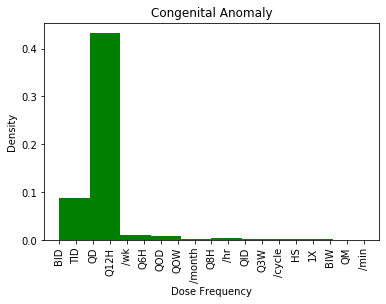

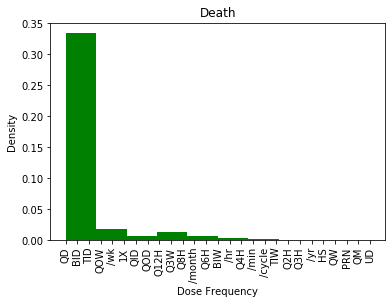

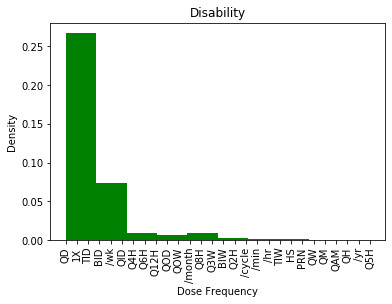

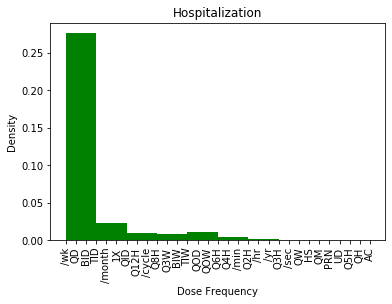

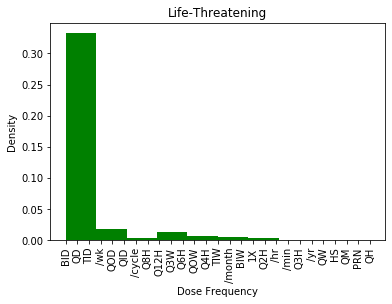

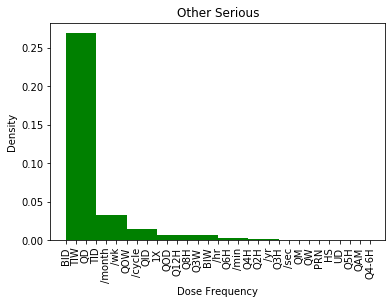

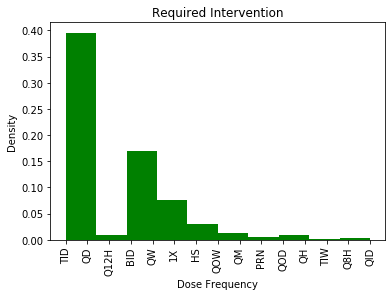

In [372]:
sub = dat[~dat['dose_freq'].isnull()]
grouped = sub.groupby('outc_cod')
for k,group in grouped:
    plt.figure()
    plt.hist(group.dose_freq,density=True, color="green")
    plt.xlabel('Dose Frequency')
    plt.ylabel('Density')
    plt.title(k)
    plt.xticks(rotation='vertical')
    plt.show()
    
#plt.figure(figsize=(70,10))
#pd.crosstab(dat.dose_freq,dat.outc_cod).plot(kind='bar')

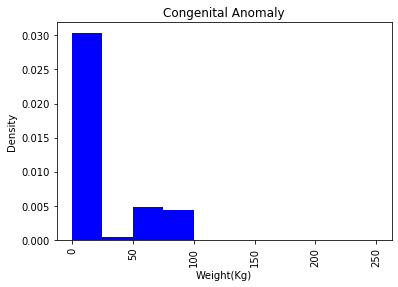

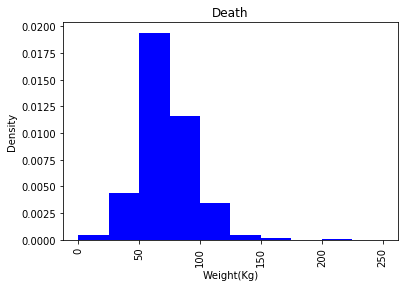

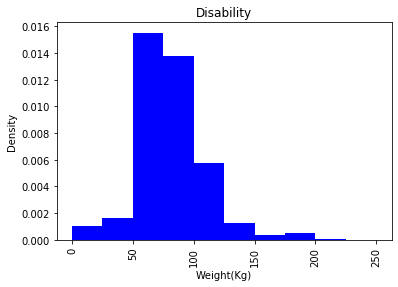

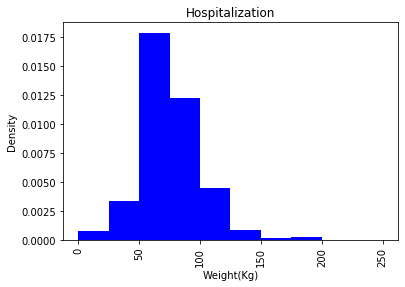

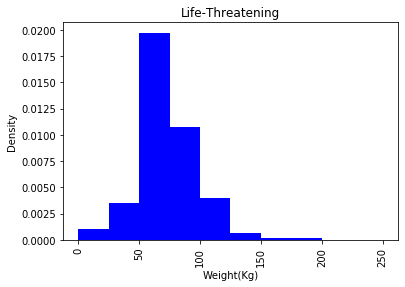

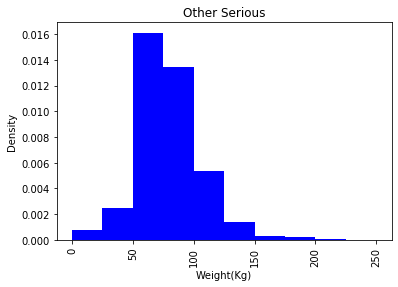

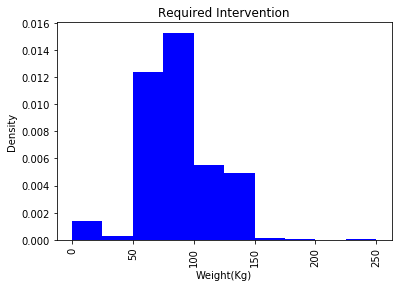

In [373]:
sub = dat[~dat['wt_kg'].isnull()]
grouped = sub.groupby('outc_cod')
for k,group in grouped:
    plt.figure()
    plt.hist(group.wt_kg,density=True, color="blue",bins=range(0,251,25))
    plt.xlabel('Weight(Kg)')
    plt.ylabel('Density')
    plt.title(k)
    plt.xticks(rotation='vertical')
    plt.show()

## Feature Selection

For now, let's start with a small subset of features.

In [374]:
#Features to be considered for prediction
cols = ['outc_cod','age', 'wt_kg' , 'sex', 'dose_freq', 'role_cod', 'route' ]
sub = dat[cols]
sub = sub.dropna()
sub = sub.drop_duplicates()



Create dummy variables for categorical variables.

In [375]:
cat_vars=['sex','dose_freq','role_cod','route']
subcat = pd.get_dummies(sub[cat_vars])
subcat['outc_cod']=sub['outc_cod']
subcat['age']=sub['age']
subcat['wt_kg']=sub['wt_kg']

Now we train a model to predict an outcome. Note that ADRs are not mutually exclusive meaning that one patient might have multiple outcomes. Therefore, a classifier is separately modeled for a single outcomes.

In [376]:
# predict hospitalization
OUT='Hospitalization'


subcat['HO']= -1
subcat['HO'] = np.where(subcat['outc_cod']==OUT, 1 , subcat['HO'])
subcat['HO'] = np.where(subcat['outc_cod']!=OUT, 0 , subcat['HO'])
train, test = train_test_split(subcat, train_size=0.80, random_state=1)
traindf = pd.DataFrame(train, columns=subcat.columns)
testdf = pd.DataFrame(test, columns=subcat.columns)

#Balanced
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.1)
#sss.get_n_splits(subcat, subcat['HO'])
#for train_idx, test_idx in sss.split(subcat, subcat['HO']):
#    traindf=subcat.iloc[train_idx]
#    testdf=subcat.iloc[test_idx]


Ytrain = traindf['HO']
Ytest = testdf['HO']


traindf.drop(['HO','outc_cod'],axis=1,inplace=True)
testdf.drop(['HO','outc_cod'],axis=1,inplace=True)

Now we filter out some features using [RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) method.

In [377]:
#RFE feature selection
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(traindf, Ytrain.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False False False  True False False False False False False False
  True  True False False False  True False False  True False False  True
 False False False  True False False False False False False False False
 False False False False False False  True  True False  True False False
  True False  True False False  True  True False False False False False
  True False False False False False  True False False False False False
  True False False False False False False False  True False False  True
  True False False False False]
[32 48 18 26  1 59 16 63  3 55 38 17  1  1 64 21 56  1  9 29  1 23 30  1
 58 35 57  1 28 60  8 43 41 20 65 34 37 39 61  5 40 13  1  1  4  1 70 62
  1 15  1 12 52  1  1 19 36 46 22 33  1 54 10 53  6 51  1 11 44 31 24 50
  1  2 14 42 45 47 66 67  1 27 49  1  1 25  7 69 68]


In [378]:
traindf = traindf.loc[:,rfe.support_]
testdf = testdf.loc[:,rfe.support_]

## Logistic Regression

In [379]:
logisticRegr = LogisticRegression(fit_intercept = False, C = 1e9)


## Accuracy

In [380]:
logisticRegr.fit(traindf, Ytrain)
predictions = logisticRegr.predict(testdf)
score = logisticRegr.score(testdf, Ytest)
print(score)

0.6054421768707483


Confusion Matrix


[[10491    49]
 [ 6853   100]]


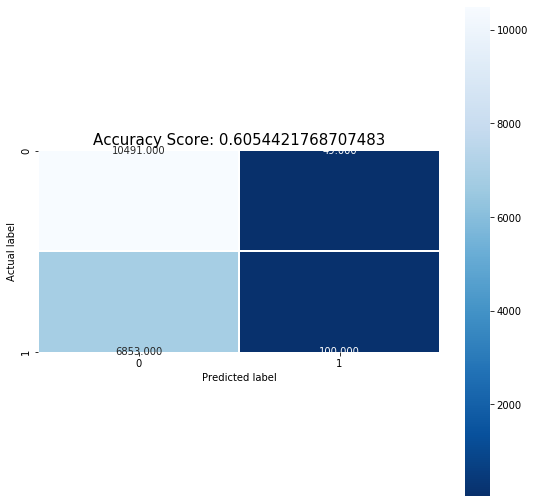

In [381]:
from sklearn import metrics
import seaborn as sns
cm = metrics.confusion_matrix(Ytest, predictions)
print(cm)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

